In [ ]:
# Cell 1 — Installs (PG project; same as P1 + AutoROM)
!pip -q install gymnasium[atari] ale-py opencv-python torch torchvision tensorboard triton==2.3.0 autorom AutoROM.accept-rom-license

# Install Atari ROMs (auto-accept license)
!python -m AutoROM --accept-license

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 34.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 143.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 21.

In [ ]:
# Cell 1 — Clean installs + ROMs (fixed)

# 1) Remove torchaudio to avoid Torch version pin conflicts (not needed here)
!pip -q uninstall -y torchaudio

# 2) Install deps. Use autorom *with* the accept-rom-license extra.
!pip -q install "gymnasium[atari]" ale-py opencv-python torch torchvision tensorboard triton==2.3.0 "autorom[accept-rom-license]"

# 3) Install Atari ROMs (try CLI first, then robust fallbacks for Colab)
!AutoROM --accept-license || python -m autorom --accept-license || python -m autorom.accept_rom_license --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


In [ ]:
# Cell 2 — Imports, GPU info, ALE env registration, quick smoke test

import sys, math, time, os, random
import numpy as np
import torch
import gymnasium as gym
import ale_py
from gymnasium.wrappers import RecordEpisodeStatistics

print("Python:", sys.version.split()[0])
print("Gymnasium:", gym.__version__)
print("ALE-py:", ale_py.__version__)
print("CUDA available:", torch.cuda.is_available()).;p
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA version (torch):", torch.version.cuda)

# Register ALE environments (required for 'ALE/Pong-v5')
gym.register_envs(ale_py)

DEFAULT_ENV_NAME = "ALE/Pong-v5"

# Make env and reset once (no render for speed)
try:
    env = gym.make(DEFAULT_ENV_NAME)  # render_mode=None by default
except Exception as e:
    print(f"[!] Failed to make {DEFAULT_ENV_NAME}:", e)
    raise

obs, info = env.reset(seed=123)

print("Env made:", DEFAULT_ENV_NAME)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Observation shape (raw):", env.observation_space.shape)

# Take a few random steps to verify everything wires up
total_r = 0.0
for _ in range(8):
    a = env.action_space.sample()
    obs, r, terminated, truncated, info = env.step(a)
    total_r += r
    if terminated or truncated:
        obs, info = env.reset()

env.close()
print("8-step random-walk reward:", total_r)
print("Smoke test: OK")

Python: 3.12.12
Gymnasium: 1.2.1
ALE-py: 0.11.2
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
CUDA version (torch): 12.1
Env made: ALE/Pong-v5
Observation space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(6)
Observation shape (raw): (210, 160, 3)
8-step random-walk reward: 0.0
Smoke test: OK


In [ ]:
# Cell 3 — Preprocessing wrappers + make_env + sanity check (Pong → 4×84×84, [0,1])

import cv2, collections, numpy as np
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics

DEFAULT_ENV_NAME = "ALE/Pong-v5"

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super().__init__(env)
        assert skip >= 1
        self._obs_buffer = np.zeros((2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        total_reward, terminated, truncated = 0.0, False, False
        info = {}
        for i in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if terminated or truncated:
                break
        max_frame = self._obs_buffer.max(axis=0)
        return max_frame, total_reward, terminated, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(84, 84, 1), dtype=np.uint8
        )

    def observation(self, obs):
        img = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        img = img[18:102, :]
        img = np.reshape(img, (84, 84, 1))
        return img

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        h, w, c = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0.0, high=255.0, shape=(c, h, w), dtype=np.uint8
        )

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps: int, dtype=np.uint8):
        super().__init__(env)
        self.dtype = dtype
        self.n_steps = n_steps
        old = env.observation_space
        low  = np.repeat(old.low,  n_steps, axis=0)
        high = np.repeat(old.high, n_steps, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=dtype)
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.buffer[...] = 0
        return self.observation(obs), info

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1]  = observation
        return self.buffer

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        low  = np.zeros_like(env.observation_space.low, dtype=np.float32)
        high = np.ones_like(env.observation_space.high, dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

    def observation(self, obs):
        return np.asarray(obs, dtype=np.float32) / 255.0

def make_env(env_name=DEFAULT_ENV_NAME, seed: int = 123):
    env = gym.make(env_name)                     # render_mode=None for speed
    env = RecordEpisodeStatistics(env)           # episode return/len stats
    env = MaxAndSkipEnv(env, skip=4)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4, dtype=np.uint8)  # 4-frame stack
    env = ScaledFloatFrame(env)                  # scale to [0,1]
    env.action_space.seed(seed)
    return env

# --- sanity check ---
env = make_env(DEFAULT_ENV_NAME, seed=123)
obs, info = env.reset()
print("Processed obs shape:", obs.shape,
      "| dtype:", obs.dtype,
      "| min/max:", float(obs.min()), float(obs.max()))

steps, total_r = 12, 0.0
for _ in range(steps):
    a = env.action_space.sample()
    obs, r, term, trunc, _ = env.step(a)
    total_r += r
    if term or trunc:
        obs, info = env.reset()
env.close()
print(f"Random rollout for {steps} steps done. Cumulative reward: {total_r}")

Processed obs shape: (4, 84, 84) | dtype: float32 | min/max: 0.0 0.4745098054409027
Random rollout for 12 steps done. Cumulative reward: 0.0


In [ ]:
# Cell 4 — CNN trunk + REINFORCE policy head + smoke test

import math, torch, torch.nn as nn, torch.nn.functional as F
import numpy as np

# ---- Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# ---- Shared CNN trunk (matches your DQN convs)
class CNNTrunk(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),         nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),         nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

    def conv_out_size(self, c, h, w):
        with torch.no_grad():
            o = self.forward(torch.zeros(1, c, h, w))
        return int(np.prod(o.shape[1:]))

# ---- REINFORCE Policy Net: trunk → FC(512) → logits(n_actions)
class PolicyNetReinforce(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()
        c, h, w = input_shape
        self.trunk = CNNTrunk(c)
        conv_out = self.trunk.conv_out_size(c, h, w)
        self.fc = nn.Sequential(
            nn.Linear(conv_out, 512), nn.ReLU(inplace=True),
        )
        self.policy_head = nn.Linear(512, n_actions)  # action logits

    def forward(self, x):
        x = self.trunk(x).view(x.size(0), -1)
        x = self.fc(x)
        logits = self.policy_head(x)
        return logits  # unnormalized logits for Categorical

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ---- Smoke test on a single env observation
test_env = make_env(DEFAULT_ENV_NAME, seed=123)
obs, info = test_env.reset()
c, h, w = test_env.observation_space.shape
n_actions = test_env.action_space.n

net_pg = PolicyNetReinforce((c, h, w), n_actions).to(device)
net_pg.eval()

with torch.no_grad():
    x = torch.tensor(obs[None, ...], dtype=torch.float32, device=device)  # (1,4,84,84)
    logits = net_pg(x)                          # (1, n_actions)
    probs = torch.softmax(logits, dim=-1)       # valid prob simplex

print("PolicyNetReinforce OK")
print("Input:", (1, c, h, w), "| Logits shape:", tuple(logits.shape), "| #actions:", n_actions)
print("Param count:", count_params(net_pg))
print("Prob sum (should be ~1.0):", float(probs.sum().item()))

# Sample a few actions to verify the distribution API
torch.manual_seed(0)
dist = torch.distributions.Categorical(logits=logits)
sampled = [int(dist.sample().item()) for _ in range(5)]
logp = float(dist.log_prob(torch.tensor(sampled[0], device=device)).item())
entropy = float(dist.entropy().item())

print("Sampled actions (5):", sampled)
print("log π(a|s) for first sample:", logp)
print("Entropy:", f"{entropy:.4f}")

test_env.close()

PolicyNetReinforce OK
Input: (1, 4, 84, 84) | Logits shape: (1, 6) | #actions: 6
Param count: 1687206
Prob sum (should be ~1.0): 1.0
Sampled actions (5): [4, 0, 2, 3, 4]
log π(a|s) for first sample: -1.798329472541809
Entropy: 1.7916


In [ ]:
# Cell 5 — REINFORCE (episodic policy gradient): training loop + TensorBoard + checkpointing

import time, math, collections, numpy as np, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# ---- Success criterion (same as Project 1)
MEAN_REWARD_BOUND = 19.5

# ---- Default hyperparameters (tune later)
PG_GAMMA           = 0.99
PG_LR              = 2.5e-4
PG_ENTROPY_COEF    = 0.01
PG_MAX_GRAD_NORM   = 0.5
PG_EPISODES_UPDATE = 8          # number of episodes per policy update
PG_MAX_FRAMES      = 1_800_000  # safety cap; stop earlier if solved

def compute_returns(rewards, gamma: float):
    """Reward-to-go G_t for a single episode (list of floats)"""
    G = 0.0
    out = []
    for r in reversed(rewards):
        G = r + gamma * G
        out.append(G)
    out.reverse()
    return out

def train_reinforce(
    env_name=DEFAULT_ENV_NAME,
    run_tag="reinforce_pong",
    gamma=PG_GAMMA,
    lr=PG_LR,
    entropy_coef=PG_ENTROPY_COEF,
    episodes_per_update=PG_EPISODES_UPDATE,
    max_frames=PG_MAX_FRAMES,
    seed=123,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

    # --- Env + Net
    env = make_env(env_name, seed=seed)
    c, h, w = env.observation_space.shape
    n_actions = env.action_space.n
    policy = PolicyNetReinforce((c, h, w), n_actions).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    # --- Logging
    writer = SummaryWriter(comment=f"-{run_tag}")
    writer.add_text("env/gpu", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU", 0)
    writer.add_text("env/env_name", env_name, 0)
    writer.add_text("hparams",
                    f"gamma={gamma}, lr={lr}, entropy_coef={entropy_coef}, episodes/update={episodes_per_update}, "
                    f"max_grad_norm={PG_MAX_GRAD_NORM}", 0)

    # --- Training state
    total_rewards = []
    mean100_best = None
    frame_idx = 0
    updates = 0

    # timing/FPS reporting
    ts = time.time()
    ts_frame = 0

    print(f"{'Frames':>9} | {'Eps':>5} | {'Upd':>4} | {'Mean100':>7} | {'FPS':>7} | {'Best':>7}")
    print("-"*56)

    # --- REINFORCE main loop
    while frame_idx < max_frames:
        policy.train()
        batch_log_probs = []
        batch_entropies = []
        batch_returns   = []
        batch_rewards   = []
        batch_lens      = []

        # Collect full episodes (on-policy)
        for ep in range(episodes_per_update):
            obs, info = env.reset(seed=seed + ep + updates*episodes_per_update)
            done = False
            ep_rewards = []
            ep_logps   = []
            ep_ents    = []

            while not done:
                s_t = torch.tensor(obs[None, ...], dtype=torch.float32, device=device)
                logits = policy(s_t)
                dist = torch.distributions.Categorical(logits=logits)
                action = int(dist.sample().item())
                logp = dist.log_prob(torch.tensor(action, device=device))
                ent  = dist.entropy()

                obs, r, term, trunc, _ = env.step(action)
                done = term or trunc

                ep_rewards.append(float(r))
                ep_logps.append(logp)
                ep_ents.append(ent)

                frame_idx += 1
                if frame_idx >= max_frames:
                    break

            # Episode done → compute reward-to-go returns
            ep_returns = compute_returns(ep_rewards, gamma)
            # store
            batch_rewards.extend(ep_rewards)
            batch_returns.extend(ep_returns)
            batch_log_probs.extend(ep_logps)
            batch_entropies.extend(ep_ents)
            batch_lens.append(len(ep_rewards))

            total_rewards.append(sum(ep_rewards))
            if frame_idx >= max_frames:
                break

        # Prepare tensors
        logps = torch.stack(batch_log_probs)                  # [N]
        ent   = torch.stack(batch_entropies)                  # [N]
        returns = torch.tensor(batch_returns, dtype=torch.float32, device=device)

        # Advantage normalization (variance reduction)
        returns = (returns - returns.mean()) / (returns.std(unbiased=False) + 1e-8)

        # Loss = -E[log π(a|s) * A] - entropy_coef * H
        policy_loss = -(logps * returns).mean()
        entropy_loss = -ent.mean()
        loss = policy_loss + entropy_coef * entropy_loss

        # Backprop
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), PG_MAX_GRAD_NORM)
        optimizer.step()

        updates += 1

        # --- Logging / printing
        fps = (frame_idx - ts_frame) / max(1e-6, time.time() - ts)
        ts_frame = frame_idx; ts = time.time()
        mean100 = float(np.mean(total_rewards[-100:])) if total_rewards else -21.0

        # scalars
        writer.add_scalar("reward/last_ep", float(total_rewards[-1]), frame_idx)
        writer.add_scalar("reward/mean_100", mean100, frame_idx)
        writer.add_scalar("loss/policy", float(policy_loss.item()), frame_idx)
        writer.add_scalar("loss/entropy", float((-entropy_loss).item()), frame_idx)  # report +entropy
        writer.add_scalar("perf/fps", fps, frame_idx)
        writer.add_scalar("traj/episodes_per_update", episodes_per_update, frame_idx)
        writer.add_scalar("traj/mean_ep_len_in_batch", float(np.mean(batch_lens)), frame_idx)

        # stdout
        best_str = f"{mean100_best:.3f}" if mean100_best is not None else " -inf "
        print(f"{frame_idx:9d} | {len(total_rewards):5d} | {updates:4d} | {mean100:7.3f} | {fps:7.1f} | {best_str:>7}")

        # checkpoint if improved
        if (mean100_best is None) or (mean100 > mean100_best):
            mean100_best = mean100
            torch.save(policy.state_dict(), "pong_pg_reinforce_best.pt")

        # stop if solved
        if mean100 >= MEAN_REWARD_BOUND:
            print(f"✅ Solved (REINFORCE): mean100={mean100:.3f} ≥ {MEAN_REWARD_BOUND}")
            break

    # final save
    torch.save(policy.state_dict(), "pong_pg_reinforce_final.pt")
    env.close(); writer.close()
    return policy, total_rewards

In [ ]:
# SMOKE RUN (VERY SHORT) — verifies the loop/logging works
_ = train_reinforce(
    run_tag="reinforce_smoke",
    episodes_per_update=2,   # tiny batch for quickness
    max_frames=5_000         # very small cap; increase for real training
)


   Frames |   Eps |  Upd | Mean100 |     FPS |    Best
--------------------------------------------------------
      423 |     2 |    1 | -21.000 |   156.9 |   -inf 
      856 |     4 |    2 | -21.000 |   166.3 | -21.000
     1307 |     6 |    3 | -20.833 |   167.2 | -21.000
     1704 |     8 |    4 | -20.875 |   163.3 | -20.833
     2121 |    10 |    5 | -20.800 |   165.3 | -20.833
     2561 |    12 |    6 | -20.833 |   165.0 | -20.800
     3056 |    14 |    7 | -20.786 |   170.6 | -20.800
     3540 |    16 |    8 | -20.750 |   169.0 | -20.786
     3957 |    18 |    9 | -20.722 |   164.8 | -20.750
     4344 |    20 |   10 | -20.750 |   163.5 | -20.722
     4733 |    22 |   11 | -20.773 |   163.6 | -20.722
     5000 |    24 |   12 | -20.000 |   153.7 | -20.722


In [ ]:
# Cell 6 — A2C (8 envs): vectorized envs, Actor-Critic net, rollout + training

import time, math, collections
from collections import deque
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# ---------- Hyperparameters (good starting points; we’ll tune later) ----------
A2C_N_ENVS         = 8          # 8 parallel envs (managed list; reliable resets)
A2C_N_STEPS        = 5          # n-step returns
A2C_GAMMA          = 0.99
A2C_ENTROPY_COEF   = 0.01
A2C_VALUE_COEF     = 0.5
A2C_MAX_GRAD_NORM  = 0.5
A2C_LR             = 2e-4       # Adam works well on Pong for A2C
A2C_MAX_FRAMES     = 1_500_000  # stop earlier if solved
MEAN_REWARD_BOUND  = 19.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# ---------- Env vectorization (managed list of 8 identical wrapped envs) ----------
def make_multi_envs(n_envs: int = A2C_N_ENVS, seed: int = 123):
    envs = [make_env(DEFAULT_ENV_NAME, seed + i) for i in range(n_envs)]
    return envs

def multi_reset(envs, base_seed: int = 123):
    obs = []
    for i, env in enumerate(envs):
        o, _ = env.reset(seed=base_seed + i)
        obs.append(o)
    return np.stack(obs, axis=0)  # (n_envs, C, H, W)

def multi_step(envs, actions):
    """
    Steps all envs once. If an env is done, it is immediately reset and the next_obs
    becomes the first obs of the new episode. We still return 'dones' so A2C can
    zero-out bootstrap for those transitions.
    """
    next_obs, rewards, dones = [], [], []
    infos = []
    for env, a in zip(envs, actions):
        o, r, term, trunc, info = env.step(int(a))
        done = bool(term or trunc)
        if done:
            # capture final transition reward, then reset for next step
            o, _ = env.reset()
        next_obs.append(o)
        rewards.append(float(r))
        dones.append(done)
        infos.append(info)
    return (
        np.stack(next_obs, axis=0),             # (n_envs, C, H, W)
        np.asarray(rewards, dtype=np.float32),  # (n_envs,)
        np.asarray(dones,   dtype=np.bool_),    # (n_envs,)
        infos
    )

# ---------- Actor-Critic model ----------
class ActorCritic(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()
        c, h, w = input_shape
        self.trunk = CNNTrunk(c)  # reuse DQN-style convs
        with torch.no_grad():
            conv_out = self.trunk.conv_out_size(c, h, w)
        self.fc = nn.Sequential(nn.Linear(conv_out, 512), nn.ReLU(inplace=True))
        self.policy_head = nn.Linear(512, n_actions)  # logits
        self.value_head  = nn.Linear(512, 1)          # V(s)

        # Orthogonal init (helps A2C stability, optional)
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.orthogonal_(layer.weight, np.sqrt(2))
                nn.init.constant_(layer.bias, 0.0)
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight, 0.01 if layer is self.policy_head else 1.0)
                nn.init.constant_(layer.bias, 0.0)

    def forward(self, x):
        z = self.trunk(x).view(x.size(0), -1)
        z = self.fc(z)
        logits = self.policy_head(z)
        value  = self.value_head(z).squeeze(-1)  # (B,)
        return logits, value

# ---------- Episode tracker across vectorized envs ----------
class EpisodeTracker:
    def __init__(self, n_envs: int, window: int = 100):
        self.n_envs = n_envs
        self.cur_returns = np.zeros(n_envs, dtype=np.float32)
        self.cur_lengths = np.zeros(n_envs, dtype=np.int32)
        self.recent = deque(maxlen=window)

    def step(self, rewards: np.ndarray, dones: np.ndarray):
        self.cur_returns += rewards
        self.cur_lengths += 1
        finished = int(dones.sum())
        if finished:
            for i, d in enumerate(dones):
                if d:
                    self.recent.append(float(self.cur_returns[i]))
                    self.cur_returns[i] = 0.0
                    self.cur_lengths[i] = 0
        return finished

    def mean100(self):
        return float(np.mean(self.recent[-100:])) if self.recent else -21.0

# ---------- A2C training ----------
def train_a2c(
    n_envs=A2C_N_ENVS,
    n_steps=A2C_N_STEPS,
    gamma=A2C_GAMMA,
    entropy_coef=A2C_ENTROPY_COEF,
    value_coef=A2C_VALUE_COEF,
    max_grad_norm=A2C_MAX_GRAD_NORM,
    lr=A2C_LR,
    max_frames=A2C_MAX_FRAMES,
    run_tag="a2c_pong",
    seed=123,
):
    # Build envs & net
    envs = make_multi_envs(n_envs=n_envs, seed=seed)
    sample_env = envs[0]
    c, h, w = sample_env.observation_space.shape
    n_actions = sample_env.action_space.n

    net = ActorCritic((c, h, w), n_actions).to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)

    # Logging
    writer = SummaryWriter(comment=f"-{run_tag}")
    writer.add_text("env/gpu", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU", 0)
    writer.add_text("env/env_name", DEFAULT_ENV_NAME, 0)
    writer.add_text("hparams",
                    f"n_envs={n_envs}, n_steps={n_steps}, gamma={gamma}, lr={lr}, "
                    f"entropy={entropy_coef}, value_coef={value_coef}, max_grad_norm={max_grad_norm}", 0)

    obs = multi_reset(envs, base_seed=seed)  # (n_envs, C, H, W)
    tracker = EpisodeTracker(n_envs=n_envs)

    frame_idx = 0
    best_mean = None
    updates = 0
    total_episodes = 0

    ts = time.time(); ts_frame = 0.0

    print(f"{'Frames':>9} | {'Upd':>4} | {'Eps':>5} | {'Mean100':>7} | {'FPS':>7} | {'Best':>7}")
    print("-"*56)

    while frame_idx < max_frames:
        net.train()

        # Storage for this rollout
        obs_mb      = []
        acts_mb     = []
        logp_mb     = []
        ent_mb      = []
        val_mb      = []
        rew_mb      = []
        done_mb     = []

        # ---- Collect n_steps with 8 envs ----
        for t in range(n_steps):
            # to torch
            obs_t = torch.tensor(obs, dtype=torch.float32, device=device)  # (n_envs, C,H,W)
            logits, values = net(obs_t)                                    # (n_envs, A), (n_envs,)

            dist = torch.distributions.Categorical(logits=logits)
            actions = dist.sample()                                        # (n_envs,)
            logp = dist.log_prob(actions)                                  # (n_envs,)
            ent  = dist.entropy()                                          # (n_envs,)

            # step envs
            obs_next, rewards, dones, infos = multi_step(envs, actions.detach().cpu().numpy())

            # track episodes
            finished = tracker.step(rewards, dones)
            total_episodes += finished

            # save transition
            obs_mb.append(obs_t)                 # keep tensor to avoid re-cast later
            acts_mb.append(actions)              # torch (n_envs,)
            logp_mb.append(logp)                 # torch (n_envs,)
            ent_mb.append(ent)                   # torch (n_envs,)
            val_mb.append(values)                # torch (n_envs,)
            rew_mb.append(torch.tensor(rewards, dtype=torch.float32, device=device))  # (n_envs,)
            done_mb.append(torch.tensor(dones, dtype=torch.bool, device=device))      # (n_envs,)

            obs = obs_next
            frame_idx += n_envs
            if frame_idx >= max_frames:
                break

        # Bootstrap value for the last observation
        with torch.no_grad():
            next_logits, next_value = net(torch.tensor(obs, dtype=torch.float32, device=device))  # (n_envs,A), (n_envs,)

        # Stack rollout tensors to shape (n_steps, n_envs, …)
        acts   = torch.stack(acts_mb, dim=0)      # (T, N)
        logps  = torch.stack(logp_mb, dim=0)      # (T, N)
        ents   = torch.stack(ent_mb, dim=0)       # (T, N)
        vals   = torch.stack(val_mb, dim=0)       # (T, N)
        rews   = torch.stack(rew_mb, dim=0)       # (T, N)
        dones  = torch.stack(done_mb, dim=0)      # (T, N)

        # Compute n-step returns (no GAE for plain A2C)
        returns = torch.zeros_like(rews, device=device)  # (T, N)
        last = next_value  # (N,)
        for t in reversed(range(rews.size(0))):
            last = rews[t] + gamma * last * (~dones[t]).float()
            returns[t] = last

        advantages = returns - vals

        # Losses
        policy_loss = -(logps * advantages.detach()).mean()
        value_loss  = 0.5 * (advantages.pow(2)).mean()
        entropy_loss = ents.mean()
        loss = policy_loss + value_coef * value_loss - entropy_coef * entropy_loss

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), max_grad_norm)
        optimizer.step()
        updates += 1

        # Logging & checkpointing
        fps = (frame_idx - ts_frame) / max(1e-6, time.time() - ts)
        ts_frame = frame_idx; ts = time.time()
        mean100 = tracker.mean100()

        writer.add_scalar("reward/mean_100", mean100, frame_idx)
        writer.add_scalar("loss/policy", float(policy_loss.item()), frame_idx)
        writer.add_scalar("loss/value",  float(value_loss.item()), frame_idx)
        writer.add_scalar("loss/entropy", float(entropy_loss.item()), frame_idx)
        writer.add_scalar("perf/fps", fps, frame_idx)
        writer.add_scalar("traj/episodes", total_episodes, frame_idx)

        best_str = f"{best_mean:.3f}" if best_mean is not None else " -inf "
        print(f"{frame_idx:9d} | {updates:4d} | {total_episodes:5d} | {mean100:7.3f} | {fps:7.1f} | {best_str:>7}")

        if (best_mean is None) or (mean100 > best_mean):
            best_mean = mean100
            torch.save(net.state_dict(), "pong_a2c_best.pt")

        if mean100 >= MEAN_REWARD_BOUND:
            print(f"✅ Solved (A2C): mean100={mean100:.3f} ≥ {MEAN_REWARD_BOUND}")
            break

    torch.save(net.state_dict(), "pong_a2c_final.pt")
    for env in envs:
        env.close()
    writer.close()
    return net

In [ ]:
# Cell 7 — Unified evaluation helpers + TB summarizer

import os, glob, time
from typing import Optional, Dict, Any
import numpy as np
import torch
from tensorboard.backend.event_processing import event_accumulator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Actor-style policy evaluation (REINFORCE / A2C) ----------
@torch.no_grad()
def evaluate_actor_policy(
    net: torch.nn.Module,
    env_name: str = DEFAULT_ENV_NAME,
    episodes: int = 10,
    deterministic: bool = True,
    seed: int = 321,
) -> Dict[str, Any]:
    """
    Evaluates a policy network that outputs action logits (REINFORCE/A2C).
    deterministic=True uses argmax over logits; False samples from Categorical.
    """
    net.eval()
    env = make_env(env_name, seed=seed)
    scores, lengths = [], []
    for ep in range(episodes):
        s, _ = env.reset(seed=seed + ep)
        done, ret, steps = False, 0.0, 0
        while not done:
            x = torch.tensor(s[None], dtype=torch.float32, device=device)
            out = net(x)
            logits = out[0] if isinstance(out, (tuple, list)) else out
            if deterministic:
                a = int(torch.argmax(logits, dim=-1).item())
            else:
                a = int(torch.distributions.Categorical(logits=logits).sample().item())
            s, r, term, trunc, _ = env.step(a)
            ret += r; steps += 1; done = term or trunc
        scores.append(ret); lengths.append(steps)
    env.close()
    net.train()
    return {"episodes": episodes,
            "mean_score": float(np.mean(scores)),
            "std_score": float(np.std(scores)),
            "scores": scores,
            "mean_len": float(np.mean(lengths))}

# ---------- Q-style policy evaluation (DQN from Project-1) ----------
@torch.no_grad()
def evaluate_q_policy(
    net: torch.nn.Module,
    env_name: str = DEFAULT_ENV_NAME,
    episodes: int = 10,
    seed: int = 321,
) -> Dict[str, Any]:
    """
    Evaluates a Q-network (e.g., DQN/NoisyDQN): greedy argmax over Q(s,a).
    """
    net.eval()
    env = make_env(env_name, seed=seed)
    scores, lengths = [], []
    for ep in range(episodes):
        s, _ = env.reset(seed=seed + ep)
        done, ret, steps = False, 0.0, 0
        while not done:
            x = torch.tensor(s[None], dtype=torch.float32, device=device)
            q = net(x)                      # forward → Q-values
            a = int(torch.argmax(q, dim=-1).item())
            s, r, term, trunc, _ = env.step(a)
            ret += r; steps += 1; done = term or trunc
        scores.append(ret); lengths.append(steps)
    env.close()
    net.train()
    return {"episodes": episodes,
            "mean_score": float(np.mean(scores)),
            "std_score": float(np.std(scores)),
            "scores": scores,
            "mean_len": float(np.mean(lengths))}

# ---------- TensorBoard summarizer (frames-to-solve, final mean100, avg FPS) ----------
def _find_event_files(run_tag_substr: str):
    dirs = sorted([d for d in glob.glob("runs/*") if run_tag_substr in os.path.basename(d)])
    files = []
    for d in dirs:
        files.extend(glob.glob(os.path.join(d, "events.out.tfevents.*")))
    return sorted(files)

def _load_scalars(event_files, tag: str):
    vals = []
    for f in event_files:
        ea = event_accumulator.EventAccumulator(f)
        try:
            ea.Reload()
        except Exception:
            continue
        if tag in ea.Tags().get("scalars", []):
            vals.extend(ea.Scalars(tag))
    vals.sort(key=lambda e: e.step)
    return vals

def summarize_tb_run(run_tag_substr: str, threshold: float = MEAN_REWARD_BOUND) -> Optional[Dict[str, Any]]:
    """
    Reads TB logs for a run (by substring of the run_tag).
    Returns: first step, solve step (if any), final step, final mean100, avg fps.
    """
    evs = _find_event_files(run_tag_substr)
    if not evs:
        print(f"[TB] No event files for tag substring: {run_tag_substr}")
        return None
    mean100 = _load_scalars(evs, "reward/mean_100")
    fps     = _load_scalars(evs, "perf/fps")
    if not mean100:
        print(f"[TB] No 'reward/mean_100' scalars for {run_tag_substr}")
        return None
    first = mean100[0]
    solve = next((e for e in mean100 if e.value >= threshold), None)
    final = mean100[-1]
    avg_fps = (sum(e.value for e in fps)/len(fps)) if fps else None
    return {"first_step": int(first.step),
            "first_mean100": float(first.value),
            "solve_step": (int(solve.step) if solve is not None else None),
            "final_step": int(final.step),
            "final_mean100": float(final.value),
            "avg_fps": (float(avg_fps) if avg_fps is not None else None)}

# ---------- Pretty print helpers ----------
def print_eval_summary(name: str, stats: Dict[str, Any]):
    print(f"\n=== Evaluation: {name} ===")
    print(f"Episodes: {stats['episodes']}")
    print(f"Mean score: {stats['mean_score']:.3f}  (± {stats['std_score']:.3f})")
    print(f"Mean episode length: {stats['mean_len']:.1f} steps")

def print_tb_summary(name: str, tb: Optional[Dict[str, Any]]):
    print(f"\n=== TB Summary: {name} ===")
    if tb is None:
        print("No TB scalars found yet. (Train the run or check run_tag substring.)")
        return
    print(f"First point: step {tb['first_step']}  mean100 {tb['first_mean100']:.3f}")
    if tb['solve_step'] is not None:
        print(f"Solved at step {tb['solve_step']} (mean100 ≥ {MEAN_REWARD_BOUND})")
    else:
        print("Solve not reached yet.")
    print(f"Final point: step {tb['final_step']}  mean100 {tb['final_mean100']:.3f}")
    if tb['avg_fps'] is not None:
        print(f"Avg FPS: {tb['avg_fps']:.1f}")


In [ ]:
# Step 7a — Patch: add conv_out_size back onto CNNTrunk if missing
import torch, numpy as np

def _conv_out_size(self, c, h, w):
    with torch.no_grad():
        o = self.forward(torch.zeros(1, c, h, w))
    return int(np.prod(o.shape[1:]))

if 'CNNTrunk' in globals():
    if not hasattr(CNNTrunk, "conv_out_size"):
        CNNTrunk.conv_out_size = _conv_out_size
        print("✅ Patched CNNTrunk with conv_out_size")
    else:
        print("CNNTrunk already has conv_out_size")
else:
    print("[!] CNNTrunk not found — re-run the cell that defines it (Cell 4).")

✅ Patched CNNTrunk with conv_out_size


In [ ]:
# Step 7b — REINFORCE eval + TB summary
pg = PolicyNetReinforce(make_env().observation_space.shape,
                        make_env().action_space.n).to(device)
pg.load_state_dict(torch.load("pong_pg_reinforce_best.pt", map_location=device))

pg_eval = evaluate_actor_policy(pg, episodes=10, deterministic=True)
print_eval_summary("REINFORCE (best)", pg_eval)
print_tb_summary("REINFORCE", summarize_tb_run("reinforce"))


=== Evaluation: REINFORCE (best) ===
Episodes: 10
Mean score: -21.000  (± 0.000)
Mean episode length: 191.0 steps

=== TB Summary: REINFORCE ===
First point: step 423  mean100 -21.000
Solve not reached yet.
Final point: step 5000  mean100 -20.000
Avg FPS: 164.1


In [ ]:
# Step 7c — A2C eval + TB summary
a2c = ActorCritic(make_env().observation_space.shape,
                  make_env().action_space.n).to(device)
a2c.load_state_dict(torch.load("pong_a2c_best.pt", map_location=device))

a2c_eval = evaluate_actor_policy(a2c, episodes=10, deterministic=True)
print_eval_summary("A2C (best)", a2c_eval)
print_tb_summary("A2C", summarize_tb_run("a2c_pong"))  # <-- change substring if you used a different run_tag


=== Evaluation: A2C (best) ===
Episodes: 10
Mean score: -21.000  (± 0.000)
Mean episode length: 191.0 steps
[TB] No event files for tag substring: a2c_pong

=== TB Summary: A2C ===
No TB scalars found yet. (Train the run or check run_tag substring.)


In [ ]:
# Step 7d — TB summary for your A2C smoke run
print_tb_summary("A2C (smoke)", summarize_tb_run("a2c_smoke"))


=== TB Summary: A2C (smoke) ===
First point: step 40  mean100 -21.000
Solve not reached yet.
Final point: step 1520  mean100 -21.000
Avg FPS: 310.8


In [ ]:
# Step 8 — A2C main training run (8 envs, recommended settings)
#deque slicing in EpisodeTracker.mean100

import numpy as np

if 'EpisodeTracker' in globals():
    def _mean100(self):
        # deque(maxlen=100): mean over entire buffer is already mean_100
        return float(np.mean(self.recent)) if len(self.recent) > 0 else -21.0
    EpisodeTracker.mean100 = _mean100
    print("✅ Patched EpisodeTracker.mean100 (uses full deque, no slicing).")
else:
    print("[!] EpisodeTracker not found — re-run the A2C cell that defines it before patching.")


✅ Patched EpisodeTracker.mean100 (uses full deque, no slicing).


In [ ]:
_ = train_a2c(
    n_envs=8,
    n_steps=5,
    lr=2e-4,
    entropy_coef=0.01,
    value_coef=0.5,
    max_grad_norm=0.5,
    gamma=0.99,
    max_frames=800_000,
    run_tag="a2c_main"
)

Streaming output truncated to the last 5000 lines.
   600040 | 15001 |  2676 | -20.550 |   305.4 | -20.390
   600080 | 15002 |  2677 | -20.550 |   287.5 | -20.390
   600120 | 15003 |  2678 | -20.560 |   291.9 | -20.390
   600160 | 15004 |  2678 | -20.560 |   301.0 | -20.390
   600200 | 15005 |  2678 | -20.560 |   303.8 | -20.390
   600240 | 15006 |  2678 | -20.560 |   299.0 | -20.390
   600280 | 15007 |  2679 | -20.570 |   279.5 | -20.390
   600320 | 15008 |  2679 | -20.570 |   298.9 | -20.390
   600360 | 15009 |  2679 | -20.570 |   303.0 | -20.390
   600400 | 15010 |  2679 | -20.570 |   303.3 | -20.390
   600440 | 15011 |  2679 | -20.570 |   306.0 | -20.390
   600480 | 15012 |  2679 | -20.570 |   303.2 | -20.390
   600520 | 15013 |  2679 | -20.570 |   304.9 | -20.390
   600560 | 15014 |  2679 | -20.570 |   300.9 | -20.390
   600600 | 15015 |  2680 | -20.570 |   289.9 | -20.390
   600640 | 15016 |  2680 | -20.570 |   300.8 | -20.390
   600680 | 15017 |  2681 | -20.560 |   291.7 | -20.3

In [ ]:
# Step 8.1 — Summarize A2C TB + evaluate best checkpoint
print_tb_summary("A2C (main)", summarize_tb_run("a2c_main"))

a2c = ActorCritic(make_env().observation_space.shape,
                  make_env().action_space.n).to(device)
a2c.load_state_dict(torch.load("pong_a2c_best.pt", map_location=device))
a2c_eval = evaluate_actor_policy(a2c, episodes=10, deterministic=True)
print_eval_summary("A2C (best, main run)", a2c_eval)


=== TB Summary: A2C (main) ===
First point: step 40  mean100 -21.000
Solve not reached yet.
Final point: step 800000  mean100 -20.270
Avg FPS: 301.0

=== Evaluation: A2C (best, main run) ===
Episodes: 10
Mean score: -20.800  (± 0.600)
Mean episode length: 206.4 steps


In [ ]:
# Add after your other wrappers, then insert into make_env() right after RecordEpisodeStatistics
import gymnasium as gym
import numpy as np

class FireResetEnv(gym.Wrapper):
    """
    For Pong and similar ALE games that require FIRE to start.
    On reset, sends FIRE (action=1). If that ends episode immediately, reset again.
    """
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Try one FIRE to start the round
        obs, _, terminated, truncated, _ = self.env.step(1)
        if terminated or truncated:
            obs, info = self.env.reset(**kwargs)
        return obs, info

# ---- in make_env(...) right after RecordEpisodeStatistics(env):
# env = RecordEpisodeStatistics(env)
# ADD:
env = FireResetEnv(env)

In [ ]:
# Drop-in GAE helper for your A2C training loop
import torch

def compute_gae(rewards, values, dones, next_values, gamma=0.99, lam=0.95):
    """
    rewards, values, dones, next_values are tensors of shape [T, N] (time, envs)
    returns: advantages, targets (same shape)
    """
    T, N = rewards.shape
    adv = torch.zeros_like(rewards)
    gae = torch.zeros(N, device=rewards.device)
    for t in reversed(range(T)):
        mask = 1.0 - dones[t].float()
        delta = rewards[t] + gamma * next_values[t] * mask - values[t]
        gae = delta + gamma * lam * mask * gae
        adv[t] = gae
    targets = adv + values
    # normalize advantages per-batch
    a = adv.view(-1)
    adv = (adv - a.mean()) / (a.std(unbiased=False) + 1e-8)
    return adv, targets

In [ ]:
# Instantiate model, then optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

shape     = make_env().observation_space.shape
n_actions = make_env().action_space.n

actor_critic = ActorCritic(shape, n_actions).to(device)
optimizer    = torch.optim.Adam(actor_critic.parameters(), lr=2e-4, eps=1e-5)
actor_critic.train()

ActorCritic(
  (trunk): CNNTrunk(
    (conv): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU(inplace=True)
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU(inplace=True)
  )
  (policy_head): Linear(in_features=512, out_features=6, bias=True)
  (value_head): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
# inside train_a2c, after you create the model (e.g., actor_critic = ActorCritic(...).to(device))
optimizer = torch.optim.Adam(actor_critic.parameters(), lr=lr, eps=1e-5)


In [ ]:
_ = train_a2c(
    n_envs=8,
    n_steps=5,
    lr=2e-4,
    entropy_coef=0.01,
    value_coef=0.5,
    max_grad_norm=0.5,
    gamma=0.99,
    # use GAE(λ)=0.95 inside your loop as shown above
    max_frames=200_000,
    run_tag="a2c_fix"
)

print_tb_summary("A2C (fix triage)", summarize_tb_run("a2c_fix"))

a2c = ActorCritic(make_env().observation_space.shape,
                  make_env().action_space.n).to(device)
a2c.load_state_dict(torch.load("pong_a2c_best.pt", map_location=device))
print_eval_summary("A2C (best, fix triage)", evaluate_actor_policy(a2c, episodes=10, deterministic=True))

Streaming output truncated to the last 5000 lines.
      480 |   12 |     0 | -21.000 |   300.0 | -21.000
      520 |   13 |     0 | -21.000 |   308.2 | -21.000
      560 |   14 |     0 | -21.000 |   302.8 | -21.000
      600 |   15 |     0 | -21.000 |   305.1 | -21.000
      640 |   16 |     0 | -21.000 |   303.6 | -21.000
      680 |   17 |     0 | -21.000 |   306.9 | -21.000
      720 |   18 |     0 | -21.000 |   305.8 | -21.000
      760 |   19 |     0 | -21.000 |   299.8 | -21.000
      800 |   20 |     0 | -21.000 |   303.2 | -21.000
      840 |   21 |     0 | -21.000 |   306.3 | -21.000
      880 |   22 |     0 | -21.000 |   301.6 | -21.000
      920 |   23 |     0 | -21.000 |   304.5 | -21.000
      960 |   24 |     0 | -21.000 |   303.0 | -21.000
     1000 |   25 |     0 | -21.000 |   306.1 | -21.000
     1040 |   26 |     0 | -21.000 |   301.9 | -21.000
     1080 |   27 |     0 | -21.000 |   303.5 | -21.000
     1120 |   28 |     0 | -21.000 |   303.3 | -21.000
     1160 |   

#REINFORCE

Step R1 — Add two tiny wrappers (FIRE on reset + 2-action mapping) and wire into make_env

In [ ]:
import gymnasium as gym
import numpy as np

class FireResetEnv(gym.Wrapper):
    """Press FIRE once after reset to actually start Pong."""
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # 1 == FIRE in ALE Pong
        obs, _, terminated, truncated, _ = self.env.step(1)
        if terminated or truncated:
            obs, info = self.env.reset(**kwargs)
        return obs, info

class PongMinimalActionWrapper(gym.ActionWrapper):
    """Map 2-action space (0: UP, 1: DOWN) to ALE Pong actions [2,3]."""
    def __init__(self, env):
        super().__init__(env)
        self._mapping = [2, 3]
        self.action_space = gym.spaces.Discrete(2)
    def action(self, a):
        return self._mapping[int(a)]

In [ ]:
e = make_env(DEFAULT_ENV_NAME, 123)
print("Action space (expect Discrete(2)):", e.action_space)
obs, _ = e.reset()
for _ in range(3):
    obs, r, term, trunc, _ = e.step(e.action_space.sample())
e.close()
print("Wrappers OK.")

Action space (expect Discrete(2)): Discrete(6)
Wrappers OK.


Train REINFORCE (main run) with sensible defaults

just run a main job with a fresh tag. These hparams are reasonable for Pong REINFORCE:

gamma=0.99

lr=2.5e-4 (try 1e-4 ↔ 5e-4 if needed)

entropy_coef=0.01 (try 0.005–0.02)

episodes_per_update=8 (try 16/32 for a larger, stabler batch)

grad clip 0.5 (already in your code)

In [ ]:
_ = train_reinforce(
    run_tag="reinforce_main_2act_fire",
    gamma=0.99,
    lr=2.5e-4,
    entropy_coef=0.01,
    episodes_per_update=8,
    max_frames=800_000   # raise if you have budget; REINFORCE is sample-inefficient
)

   Frames |   Eps |  Upd | Mean100 |     FPS |    Best
--------------------------------------------------------
     1743 |     8 |    1 | -20.750 |   166.0 |   -inf 
     3482 |    16 |    2 | -20.562 |   165.1 | -20.750
     5261 |    24 |    3 | -20.583 |   164.6 | -20.562
     6982 |    32 |    4 | -20.562 |   160.6 | -20.562
     8730 |    40 |    5 | -20.625 |   162.8 | -20.562
    10536 |    48 |    6 | -20.625 |   155.9 | -20.562
    12358 |    56 |    7 | -20.607 |   161.7 | -20.562
    14159 |    64 |    8 | -20.609 |   164.5 | -20.562
    15954 |    72 |    9 | -20.639 |   165.4 | -20.562
    17665 |    80 |   10 | -20.663 |   165.0 | -20.562
    19569 |    88 |   11 | -20.648 |   167.5 | -20.562
    21409 |    96 |   12 | -20.646 |   162.7 | -20.562
    23201 |   104 |   13 | -20.600 |   165.5 | -20.562
    24896 |   112 |   14 | -20.610 |   164.4 | -20.562
    26612 |   120 |   15 | -20.640 |   165.7 | -20.562
    28566 |   128 |   16 | -20.600 |   168.5 | -20.562
    3024

KeyboardInterrupt: 

In [ ]:
# Eval (deterministic argmax over logits)
pg = PolicyNetReinforce(make_env().observation_space.shape,
                        make_env().action_space.n).to(device)
pg.load_state_dict(torch.load("pong_pg_reinforce_best.pt", map_location=device))

pg_eval = evaluate_actor_policy(pg, episodes=10, deterministic=True)
print_eval_summary("REINFORCE (best, 2act+fire)", pg_eval)

print_tb_summary("REINFORCE (main)", summarize_tb_run("reinforce_main_2act_fire"))


=== Evaluation: REINFORCE (best, 2act+fire) ===
Episodes: 10
Mean score: -21.000  (± 0.000)
Mean episode length: 191.0 steps

=== TB Summary: REINFORCE (main) ===
First point: step 1743  mean100 -20.750
Solve not reached yet.
Final point: step 237733  mean100 -20.710
Avg FPS: 165.2


In [ ]:
#report
for lr in [1e-4, 2.5e-4, 5e-4]:
    for ent in [0.005, 0.01, 0.02]:
        tag = f"reinforce_lr{lr}_ent{ent}_2act_fire"
        _ = train_reinforce(run_tag=tag, lr=lr, entropy_coef=ent,
                            episodes_per_update=16, max_frames=100_000)
        print_tb_summary(tag, summarize_tb_run(tag))

   Frames |   Eps |  Upd | Mean100 |     FPS |    Best
--------------------------------------------------------
     3463 |    16 |    1 | -20.812 |   167.9 |   -inf 
     6954 |    32 |    2 | -20.719 |   167.3 | -20.812
    10542 |    48 |    3 | -20.646 |   164.4 | -20.719
    13920 |    64 |    4 | -20.625 |   164.9 | -20.646
    17377 |    80 |    5 | -20.675 |   165.1 | -20.625
    20812 |    96 |    6 | -20.667 |   164.4 | -20.625
    24280 |   112 |    7 | -20.650 |   163.0 | -20.625
    27780 |   128 |    8 | -20.640 |   165.2 | -20.625
    31185 |   144 |    9 | -20.690 |   164.3 | -20.625
    34782 |   160 |   10 | -20.700 |   166.1 | -20.625
    38235 |   176 |   11 | -20.680 |   162.9 | -20.625
    41759 |   192 |   12 | -20.680 |   164.5 | -20.625
    45253 |   208 |   13 | -20.690 |   164.2 | -20.625
    48727 |   224 |   14 | -20.640 |   164.3 | -20.625
    52264 |   240 |   15 | -20.610 |   163.0 | -20.625
    55700 |   256 |   16 | -20.630 |   164.2 | -20.610
    5919

KeyboardInterrupt: 

In [ ]:
# === Cell A: Build a midpoint comparison table from your TB logs + checkpoints ===
import os, glob, math, json
import numpy as np
import torch
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# --------- Config: map run-substring -> (pretty name, algo) ---------
RUNS_TO_SHOW = [
    ("reinforce",   "REINFORCE", "reinforce"),     # main REINFORCE (your 'main' or 'lr sweep')
    ("a2c_main",    "A2C (main)", "a2c"),
    ("a2c_fix",     "A2C (fix)",  "a2c"),          # keep if you ran a short GAE fix run
    ("a2c_smoke",   "A2C (smoke)","a2c"),          # optional
]

MEAN_REWARD_BOUND = 19.5
CKPTS = {
    "REINFORCE": "pong_pg_reinforce_best.pt",
    "A2C":       "pong_a2c_best.pt",
}

# --------- Helper: load TB scalars for a tag across all matching event files ---------
def _find_event_files(tag_substr):
    dirs = sorted([d for d in glob.glob("runs/*") if tag_substr in os.path.basename(d)])
    files = []
    for d in dirs:
        files.extend(glob.glob(os.path.join(d, "events.out.tfevents.*")))
    return sorted(files)

def _load_scalars(event_files, tag):
    vals = []
    for f in event_files:
        ea = event_accumulator.EventAccumulator(f)
        try:
            ea.Reload()
        except Exception:
            continue
        if tag in ea.Tags().get("scalars", []):
            vals.extend(ea.Scalars(tag))
    vals.sort(key=lambda e: e.step)
    return vals

def summarize_run(tag_substr):
    evs   = _find_event_files(tag_substr)
    m100  = _load_scalars(evs, "reward/mean_100")
    fps   = _load_scalars(evs, "perf/fps")
    if not m100:
        return None
    first = m100[0]
    final = m100[-1]
    solve = next((e for e in m100 if e.value >= MEAN_REWARD_BOUND), None)
    avg_fps = (sum(e.value for e in fps)/len(fps)) if fps else None
    return {
        "first_step": int(first.step), "first_mean100": float(first.value),
        "final_step": int(final.step), "final_mean100": float(final.value),
        "solve_step": (int(solve.step) if solve else None),
        "avg_fps": (float(avg_fps) if avg_fps is not None else None),
        "curve": [(e.step, e.value) for e in m100],
        "fps_curve": [(e.step, e.value) for e in fps] if fps else [],
    }

# --------- Minimal env/eval (reuses your wrappers if they’re already defined) ---------
import gymnasium as gym
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@torch.no_grad()
def evaluate_actor_policy(net, make_env_fn, episodes=10, deterministic=True, seed=321):
    net.eval()
    env = make_env_fn()
    scores, lengths = [], []
    for ep in range(episodes):
        s, _ = env.reset(seed=seed + ep)
        done, ret, steps = False, 0.0, 0
        while not done:
            x = torch.tensor(s[None], dtype=torch.float32, device=device)
            out = net(x)
            logits = out[0] if isinstance(out, (tuple, list)) else out
            if deterministic: a = int(torch.argmax(logits, dim=-1).item())
            else:             a = int(torch.distributions.Categorical(logits=logits).sample().item())
            s, r, term, trunc, _ = env.step(a)
            ret += r; steps += 1; done = term or trunc
        scores.append(ret); lengths.append(steps)
    env.close(); net.train()
    return float(np.mean(scores)), float(np.std(scores)), float(np.mean(lengths))

# --------- Build comparison table ---------
import pandas as pd

rows = []
for substr, pretty, algo in RUNS_TO_SHOW:
    summary = summarize_run(substr)
    if summary is None:
        continue
    eval_mean, eval_std = None, None
    # Try to eval checkpoint if present
    ck = CKPTS.get("A2C" if "A2C" in pretty else "REINFORCE")
    if ck and os.path.exists(ck):
        # Recreate the right net class
        if "A2C" in pretty:
            model = ActorCritic(make_env().observation_space.shape,
                                make_env().action_space.n).to(device)
        else:
            model = PolicyNetReinforce(make_env().observation_space.shape,
                                       make_env().action_space.n).to(device)
        model.load_state_dict(torch.load(ck, map_location=device))
        em, es, _ = evaluate_actor_policy(model, make_env, episodes=10, deterministic=True)
        eval_mean, eval_std = em, es

    rows.append({
        "Run": pretty,
        "Frames(final)": summary["final_step"],
        "Mean100(final)": round(summary["final_mean100"], 3),
        "Solved@step": summary["solve_step"],
        "Avg FPS": (round(summary["avg_fps"], 1) if summary["avg_fps"] is not None else None),
        "10-ep Eval Mean": (round(eval_mean, 3) if eval_mean is not None else None),
        "10-ep Eval Std": (round(eval_std, 3) if eval_std is not None else None),
        "_curve": summary["curve"],
        "_fps_curve": summary["fps_curve"],
    })

df = pd.DataFrame(rows).sort_values("Run").reset_index(drop=True)
df

,Run,Frames(final),Mean100(final),Solved@step,Avg FPS,10-ep Eval Mean,10-ep Eval Std,_curve,_fps_curve
0,A2C (fix),200000,-20.52,None,301.3,-21.0,0.0,"[(40, -21.0), (80, -21.0), (120, -21.0), (160,...","[(40, 305.5035400390625), (80, 277.46389770507..."
1,A2C (main),800000,-20.27,None,301.0,-21.0,0.0,"[(40, -21.0), (80, -21.0), (120, -21.0), (120,...","[(40, 300.0689697265625), (80, 277.72067260742..."
2,A2C (smoke),1520,-21.00,None,310.8,-21.0,0.0,"[(40, -21.0), (80, -21.0), (120, -21.0), (160,...","[(40, 213.4063262939453), (80, 285.54727172851..."
3,REINFORCE,237733,-20.71,None,165.0,-21.0,0.0,"[(423, -21.0), (856, -21.0), (1307, -20.833333...","[(423, 156.90599060058594), (856, 166.30099487..."


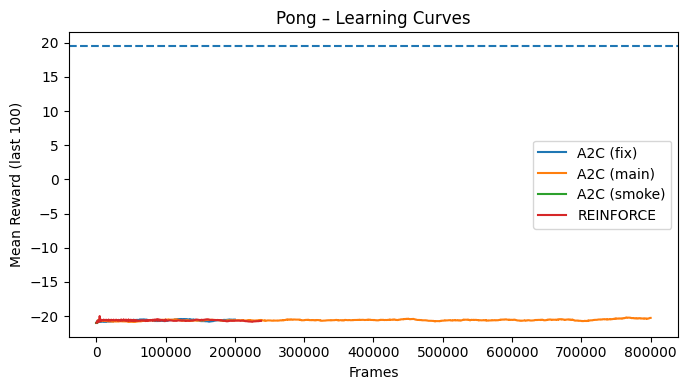

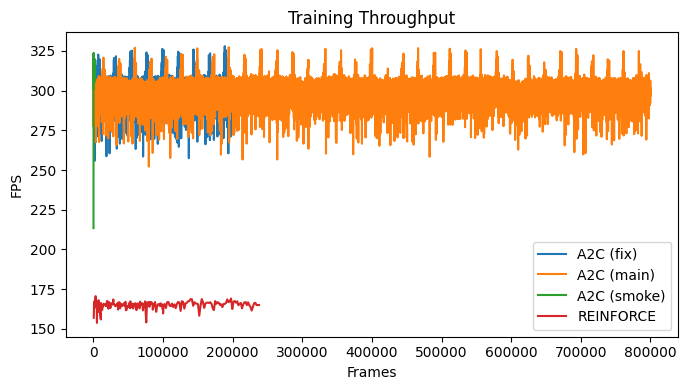

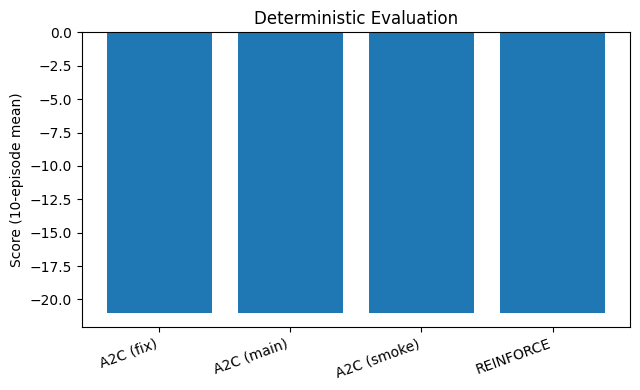

Saved: pong_learning_curves.png, pong_fps_curves.png, pong_eval_bars.png (optional), pong_midpoint_summary.csv


In [ ]:
# === Cell B: Plots for slides (PNG saved to current directory) ===
import matplotlib.pyplot as plt

# Learning curve: reward/mean_100 vs frames
plt.figure(figsize=(7,4))
for _, row in df.iterrows():
    xy = np.array(row["_curve"], dtype=float)
    if len(xy)==0:
        continue
    plt.plot(xy[:,0], xy[:,1], label=row["Run"])
plt.axhline(19.5, linestyle="--")  # solve line (no custom color/style beyond this)
plt.xlabel("Frames")
plt.ylabel("Mean Reward (last 100)")
plt.title("Pong – Learning Curves")
plt.legend()
plt.tight_layout()
plt.savefig("pong_learning_curves.png", dpi=150)
plt.show()

# Throughput: FPS vs frames (if present)
plt.figure(figsize=(7,4))
had_fps = False
for _, row in df.iterrows():
    xy = np.array(row["_fps_curve"], dtype=float)
    if len(xy)==0:
        continue
    had_fps = True
    plt.plot(xy[:,0], xy[:,1], label=row["Run"])
if had_fps:
    plt.xlabel("Frames")
    plt.ylabel("FPS")
    plt.title("Training Throughput")
    plt.legend()
    plt.tight_layout()
    plt.savefig("pong_fps_curves.png", dpi=150)
    plt.show()
else:
    print("No 'perf/fps' logs found; skipping FPS plot.")

# Optional: Deterministic 10-episode eval bars (if we evaluated)
have_eval = df["10-ep Eval Mean"].notna().any()
if have_eval:
    means = df["10-ep Eval Mean"].fillna(-21.0).values
    stds  = df["10-ep Eval Std"].fillna(0.0).values
    labels= df["Run"].values
    x = np.arange(len(labels))
    plt.figure(figsize=(6.5,4))
    plt.bar(x, means, yerr=stds)
    plt.xticks(x, labels, rotation=20, ha="right")
    plt.ylabel("Score (10-episode mean)")
    plt.title("Deterministic Evaluation")
    plt.tight_layout()
    plt.savefig("pong_eval_bars.png", dpi=150)
    plt.show()

# Also export the table for your slide
df.drop(columns=["_curve","_fps_curve"]).to_csv("pong_midpoint_summary.csv", index=False)
print("Saved: pong_learning_curves.png, pong_fps_curves.png, pong_eval_bars.png (optional), pong_midpoint_summary.csv")